# Perovskites

In this notebook, we demonstrate some of the initial work on this project that was carried out in the summer of 2021. Here, we leverage some Xenonpy-calculated properties to calculate the unit cell volume of several perovskite systems taken from NOMAD's database.

Both SISSO and TPOT are used to train predictive models, and near the end of the document we discuss what we can learn from this comparison.

Overall, in this notebook we demonstrate SISSO's ability to generate simple, interpretable models that can help lead us to physical insight - one of the major strengths of symbolic regression.

In [1]:
import functools
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tpot
import sklearn
import optuna
import xgboost
import pymatgen
import xenonpy.descriptor
from tqdm.notebook import tqdm 
import sys, os

sys.path.append("../../../")
import DigitalEcosystem.utils.figures
from DigitalEcosystem.utils.functional import except_with_default_value
from DigitalEcosystem.utils.misc import matminer_descriptors
from DigitalEcosystem.utils.element_symbols import noble_gases, f_block_elements, synthetic_elements_in_d_block

from IPython.display import Latex

pd.options.mode.chained_assignment = None 
tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 42
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [72]:
# Plot Configuration
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams["font.size"] = 32

# Read in the Data

Read the data

In [5]:
data = pd.read_pickle('../feature_engineering/full_featurized_data.pkl')


# Drop any missing entries
target_column = ["bandgap (eV)"]
data = data[data[target_column[0]].notna()]

# # Drop anything in the f-block, larger than U, and noble gases
bad_elements = noble_gases + f_block_elements + synthetic_elements_in_d_block
element_mask = data['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

# Drop anything that decomposes
decomposition_mask = data['decomposition_energy (eV/atom)'] < 0.5

# Drop things with non-strictly-positive exfoliation energies
exfol_mask = data['exfoliation_energy_per_atom (eV/atom)'] > 0

data = data[element_mask & decomposition_mask & exfol_mask]

# A parent Materials Project structure is not defined for the bottom-up materials. We waste our bandwith looking these up, so let's remove them.
data = data[data['discovery_process (unitless)'] != 'bottom-up']

In [6]:
rester = pymatgen.ext.matproj.MPRester(api_key=os.getenv("MATERIALS_PROJECT_API_KEY"))


@except_with_default_value(default_return=None)
def get_mp_bandgap(structure):
    mp_id = DigitalEcosystem.utils.misc.get_parent_structure_id(structure)
    
    result = rester.get_data(mp_id, prop='band_gap')[0]['band_gap']
    return result
    
data['mp_bandgap'] = data['2dm_id (unitless)'].progress_apply(get_mp_bandgap)

  0%|          | 0/1879 [00:00<?, ?it/s]

In [9]:
# The above featurization takes a while, so let's just save it to disk
data.to_pickle('filtered_data_with_bandgap.pkl')
#data = pd.read_pickle('filtered_data_with_bandgap.pkl')

In [13]:
# Finally, we'll filter the data with missing values for bandgap
data = data[data['mp_bandgap'].notna()]

In [15]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]

descriptors = xenonpy_descriptors + matminer_descriptors + ['mp_bandgap']

# Prepare Data

In [34]:
train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)

train_x = np.nan_to_num(train[descriptors].to_numpy())
train_y = np.nan_to_num(train[target_column].to_numpy())

test_x = np.nan_to_num(test[descriptors].to_numpy())
test_y = np.nan_to_num(test[target_column].to_numpy())

In [35]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

# XGBoost

In [40]:
current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x), train_y, test_size=0.2, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg


    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 2),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 2),
        'max_depth': trial.suggest_int('max_depth', 1, 256),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }
    
    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_reg = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(**params,
                                               n_estimators=256,
                                               n_jobs=1,
                                               objective='reg:squarederror',
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 50,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    mse = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_reg,
        y_pred=current_reg.predict(objective_validation_x_reg),
    )
    rmse = np.sqrt(mse)

    return rmse

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=256),
    direction='minimize')

reg_study.optimize(func=objective, n_trials=1000, callbacks=[keep_best_reg])

[I 2021-10-05 16:11:44,211] A new study created in memory with name: no-name-b3e851b0-7784-4523-b1a0-62fb039f333b
[I 2021-10-05 16:11:48,100] Trial 0 finished with value: 0.7336210129406551 and parameters: {'learning_rate': 0.749080237694725, 'min_split_loss': 1.9014286128198323, 'max_depth': 188, 'min_child_weight': 5.986584841970366, 'reg_lambda': 0.31203728088487304, 'reg_alpha': 0.3119890406724053, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.7336210129406551.
[I 2021-10-05 16:11:49,707] Trial 1 finished with value: 0.729603568677646 and parameters: {'learning_rate': 1.2022300234864176, 'min_split_loss': 1.416145155592091, 'max_depth': 6, 'min_child_weight': 9.699098521619943, 'reg_lambda': 1.6648852816008435, 'reg_alpha': 0.4246782213565523, 'scaler': 'MinMaxScaler'}. Best is trial 1 with value: 0.729603568677646.
[I 2021-10-05 16:11:49,982] Trial 2 pruned. Trial was pruned at iteration 3.
[I 2021-10-05 16:11:50,130] Trial 3 pruned. Trial was pruned at iteration 1.
[I 

/Users/mat3ra/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


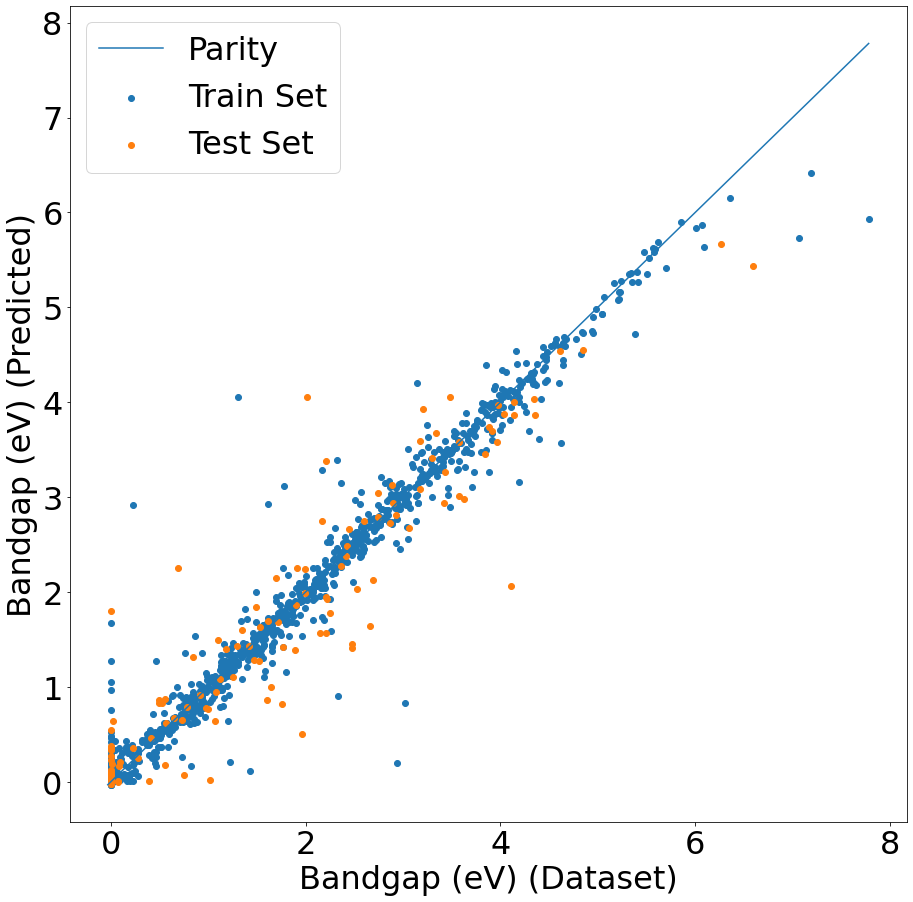

In [76]:
DigitalEcosystem.utils.figures.publication_parity_plot(train_y_true = train_y,
                                                       train_y_pred = best_reg.predict(train_x),
                                                       test_y_true = test_y,
                                                       test_y_pred = best_reg.predict(test_x),
                                                       axis_label = "Bandgap (eV)",
                                                       filename = "xgboost_2dm_bandgap_parity.jpeg")

In [55]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=best_reg.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=best_reg.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 2.041
MAE 0.3108
MSE 0.248
RMSE 0.498
MAPE 159555155287487.56
R2 0.8923

Training Set Error Metrics
MaxError 2.7507
MAE 0.1168
MSE 0.0642
RMSE 0.2534
MAPE 72957204032215.34
R2 0.9729


# TPOT

In [56]:
tpot_model = tpot.TPOTRegressor(
    generations=10,
    population_size=100,
    max_eval_time_mins=10 / 60,
    cv=10,
    verbosity=2,
    scoring="neg_root_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=-1,
    random_state=1234
)

tpot_model.fit(train_x, train_y.ravel())

Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.4412929205423147

Generation 2 - Current best internal CV score: -0.4412929205423147

Generation 3 - Current best internal CV score: -0.4412929205423147

Generation 4 - Current best internal CV score: -0.4412929205423147

Generation 5 - Current best internal CV score: -0.43823087510951797

Generation 6 - Current best internal CV score: -0.4382308751095178

Generation 7 - Current best internal CV score: -0.42913666917227467

Generation 8 - Current best internal CV score: -0.42913666917227467

Generation 9 - Current best internal CV score: -0.42913666917227467

Generation 10 - Current best internal CV score: -0.42913666917227467

Best pipeline: ElasticNetCV(MinMaxScaler(input_matrix), l1_ratio=0.9500000000000001, tol=1e-05)


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

/Users/mat3ra/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


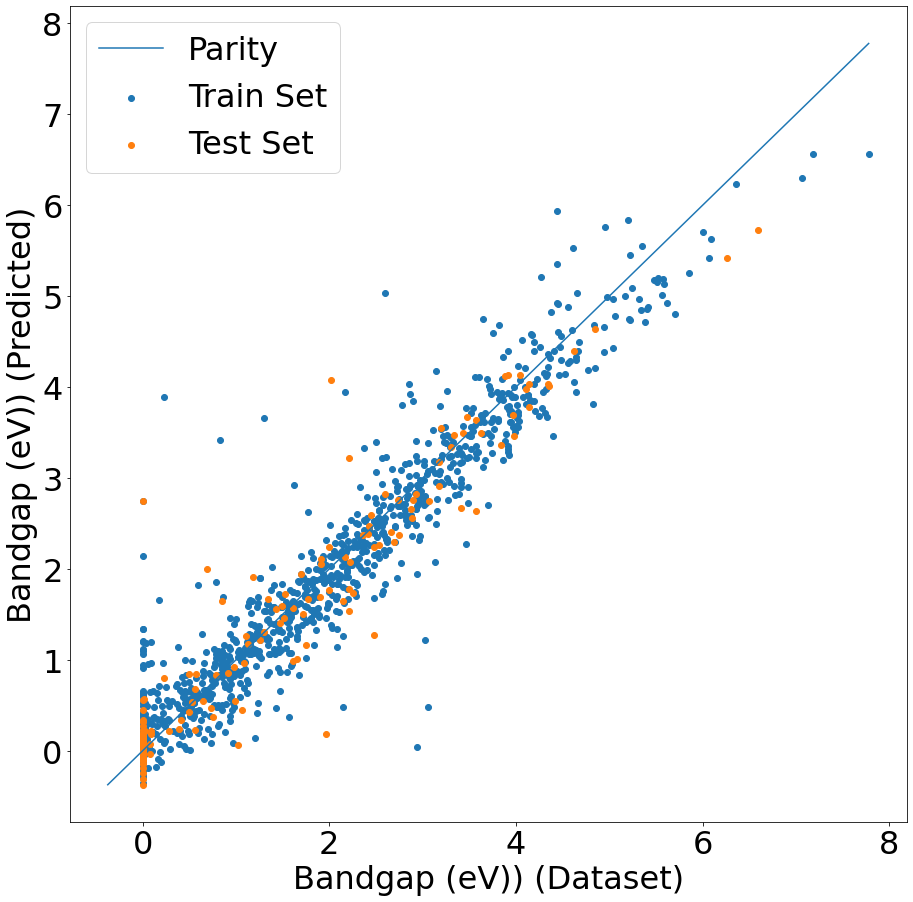

In [75]:
DigitalEcosystem.utils.figures.publication_parity_plot(train_y_true = train_y,
                                                       train_y_pred = tpot_model.predict(train_x),
                                                       test_y_true = test_y,
                                                       test_y_pred = tpot_model.predict(test_x),
                                                       axis_label = "Bandgap (eV))",
                                                       filename = "tpot_2dm_bandgap_parity.jpeg")

In [69]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=tpot_model.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=tpot_model.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 2.7494
MAE 0.2941
MSE 0.2302
RMSE 0.4798
MAPE 270736960762340.72
R2 0.9001

Training Set Error Metrics
MaxError 3.6586
MAE 0.2664
MSE 0.1702
RMSE 0.4126
MAPE 236507185442103.97
R2 0.9281


# Roost

In [44]:
roost_dir = "./roost"
os.makedirs(roost_dir, exist_ok=True)
roost_data_train = train[['formula'] + target_column]
roost_data_test = test[['formula'] + target_column]

roost_data_train.to_csv(os.path.join(roost_dir, 'roost_train.csv'), index_label='material_id')
roost_data_test.to_csv(os.path.join(roost_dir, 'roost_test.csv'), index_label='material_id')

At this point, Roost models were run. Logs can be found in the Roost directory, along with the resultant predictions.

In [47]:
roost_train_results = pd.read_csv("roost/roost_train_predictions.csv", index_col="material_id")
roost_test_results  = pd.read_csv("roost/roost_test_predictions.csv", index_col="material_id")

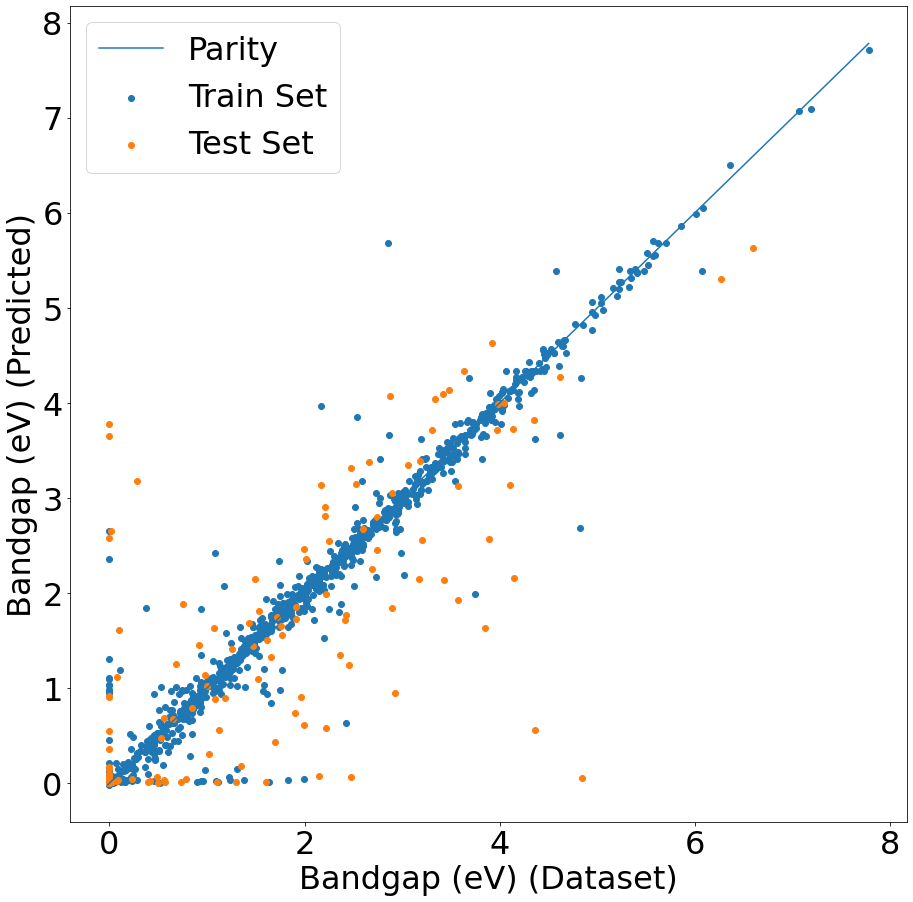

In [74]:
DigitalEcosystem.utils.figures.publication_parity_plot(train_y_true = roost_train_results['bandgap_target'],
                                                       train_y_pred =  roost_train_results['bandgap_pred_n0'],
                                                       test_y_true = roost_test_results['bandgap_target'],
                                                       test_y_pred = roost_test_results['bandgap_pred_n0'],
                                                       axis_label = "Bandgap (eV)",
                                                       filename = "roost_2dm_bandgap_parity.jpeg")

In [53]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_test_results['bandgap_target'], y_pred=roost_test_results['bandgap_pred_n0'])
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_train_results['bandgap_target'], y_pred=roost_train_results['bandgap_pred_n0'])
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 4.796
MAE 0.6532
MSE 1.1365
RMSE 1.0661
MAPE 430928609691678.9
R2 0.5066

Training Set Error Metrics
MaxError 2.827
MAE 0.1057
MSE 0.0755
RMSE 0.2748
MAPE 65116283251233.15
R2 0.9681


# SISSO

Start by obtaining importance scores from the XGBoost model

In [37]:
sisso_feature_selector = sklearn.feature_selection.SelectFromModel(sklearn.linear_model.LassoCV(random_state=RANDOM_SEED),
                                                                   threshold=-np.inf,
                                                                   max_features=16,
                                                                   prefit=False)
sisso_feature_selector.fit(train_x, train_y.ravel())

sisso_features = [col for (col, is_selected) in zip(train[descriptors].columns, sisso_feature_selector.get_support()) if is_selected]
print("\n".join(sisso_features))

ave:Polarizability
ave:atomic_number
ave:atomic_radius
ave:atomic_radius_rahm
ave:atomic_volume
ave:atomic_weight
ave:boiling_point
ave:bulk_modulus
sum:hhi_p
var:boiling_point
var:c6_gb
var:hhi_p
var:hhi_r
var:melting_point
var:sound_velocity
var:thermal_conductivity


In [39]:
sisso_dir = "./sisso"
os.makedirs(sisso_dir, exist_ok=True)

sisso_data_train = train[target_column + sisso_features]
sisso_data_test = test[target_column + sisso_features]

sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_train.csv'), index_label='2dm_id (unitless)')

At this point, a SISSO model was run.

In [79]:
sisso_models = {
    'r1_1term': lambda df: 5.908677334854443e+00 + \
                           -4.182238907095930e-01 * (np.cbrt(df['ave:boiling_point'])),
    
    'r1_2term': lambda df: 5.504823956253627e+00 + \
                           5.835997703571167e-05 * (df['var:sound_velocity'] / df['ave:boiling_point']) + \
                           -3.985388107700386e-01 * (np.cbrt(df['ave:boiling_point'])),
    
    'r1_3term': lambda df: 5.845649605906377e+00 + \
                           -2.776972308247497e-02 * (df['var:thermal_conductivity'] / df['ave:boiling_point']) + \
                           5.750580034281170e-05 * (df['var:sound_velocity'] / df['ave:boiling_point']) + \
                           -4.173209991561449e-01 * (np.cbrt(df['ave:boiling_point'])),
    
    'r1_4term': lambda df: 4.337750956240681e+00 + \
                           2.942979316747696e-04 * (df['sum:hhi_p'] / df['ave:atomic_weight']) + \
                           -2.804305577683217e-02 * (df['var:thermal_conductivity'] / df['ave:boiling_point']) + \
                           2.931501751528727e-08 * (df['var:sound_velocity'] + df['var:boiling_point']) + \
                           -8.765265123769861e-02 * (np.sqrt(df['ave:boiling_point'])),
    
    'r2_1term': lambda df: -1.620471055253183e+00 + \
                           1.826376438466298e-01 * ((df['ave:atomic_radius'] / df['ave:atomic_number']) + (df['ave:atomic_volume'] - df['ave:Polarizability'])),
    
    'r2_2term': lambda df: 4.505248526916998e-02 + \
                           -5.114170240526208e-02 * abs((df['ave:boiling_point'] / df['ave:atomic_radius']) - (df['var:thermal_conductivity'] / df['ave:boiling_point']))  + 
                           9.008103812101369e-01 * (abs(df['ave:atomic_volume'] - df['ave:Polarizability']) / np.sqrt(df['ave:atomic_number'])),
    
    'r2_3term': lambda df: -9.276197718364346e+00 + \
                           -4.769165630634773e+00 * ((df['ave:atomic_number'] / df['ave:atomic_radius']) - (df['ave:atomic_weight'] / df['ave:atomic_number'])) + \
                           -4.679352393536426e-02 * abs((df['ave:boiling_point'] / df['ave:atomic_radius']) - (df['var:thermal_conductivity'] / df['ave:boiling_point'])) + \
                           2.032274282919613e-02 * ((df['ave:atomic_radius'] / df['ave:atomic_number']) * (df['ave:atomic_volume'] - df['ave:Polarizability'])),
    
    'r2_4term': lambda df: -8.836378448679033e+00 + \
                           1.553680319666299e-03 * ((df['var:sound_velocity'] + df['var:hhi_p']) / (df['ave:bulk_modulus'] * df['ave:boiling_point'])) + \
                           -4.504845866684036e+00 * ((df['ave:atomic_number'] / df['ave:atomic_radius']) - (df['ave:atomic_weight'] / df['ave:atomic_number'])) + \
                           -4.228470995480253e-02 * abs((df['ave:boiling_point'] / df['ave:atomic_radius']) - (df['var:thermal_conductivity'] / df['ave:boiling_point'])) + \
                           1.840996252939134e-02 * ((df['ave:atomic_radius'] / df['ave:atomic_number']) * (df['ave:atomic_volume'] - df['ave:Polarizability']))
}

for key, fun in sisso_models.items():
    print(f"==========\nSISSO Model {key}")
    sisso_train_predictions = fun(sisso_data_train)
    sisso_test_predictions = fun(sisso_data_test)
    sisso_data_train[key] = sisso_train_predictions
    sisso_data_test[key] = sisso_test_predictions
    
    print("\nTest Set Error Metrics")
    for metric, fun in metrics.items():
        value = fun(y_true=sisso_data_test['bandgap (eV)'], y_pred=sisso_test_predictions)
        print(metric,np.round(value,4))

    print("\nTraining Set Error Metrics")
    for metric, fun in metrics.items():
        value = fun(y_true=sisso_data_train['bandgap (eV)'], y_pred=sisso_train_predictions)
        print(metric,np.round(value,4))
    
    


SISSO Model r1_1term

Test Set Error Metrics
MaxError 4.6529
MAE 1.0019
MSE 1.6555
RMSE 1.2867
MAPE 1276569198987335.8
R2 0.2812

Training Set Error Metrics
MaxError 5.6693
MAE 1.0192
MSE 1.6782
RMSE 1.2954
MAPE 1254231211937701.0
R2 0.2914
SISSO Model r1_2term

Test Set Error Metrics
MaxError 3.4424
MAE 0.9547
MSE 1.4657
RMSE 1.2107
MAPE 1175290549229394.0
R2 0.3637

Training Set Error Metrics
MaxError 5.8189
MAE 0.9627
MSE 1.5153
RMSE 1.231
MAPE 1177525784592379.0
R2 0.3602
SISSO Model r1_3term

Test Set Error Metrics
MaxError 3.3112
MAE 0.9307
MSE 1.387
RMSE 1.1777
MAPE 1126397053764836.8
R2 0.3978

Training Set Error Metrics
MaxError 6.0337
MAE 0.9312
MSE 1.4457
RMSE 1.2024
MAPE 1131051223078387.0
R2 0.3895
SISSO Model r1_4term

Test Set Error Metrics
MaxError 3.317
MAE 0.9218
MSE 1.3811
RMSE 1.1752
MAPE 1126109856758396.5
R2 0.4004

Training Set Error Metrics
MaxError 5.9906
MAE 0.9171
MSE 1.3911
RMSE 1.1794
MAPE 1130435864707229.2
R2 0.4126
SISSO Model r2_1term

Test Set Error Me

It's not the best model, but we're gonna use the Rung1 1Term model, because it's simple and still performs well. It's also intuitive.

In [64]:
sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_results_train.csv'))
sisso_data_test.to_csv(os.path.join(sisso_dir, 'sisso_results_test.csv'))

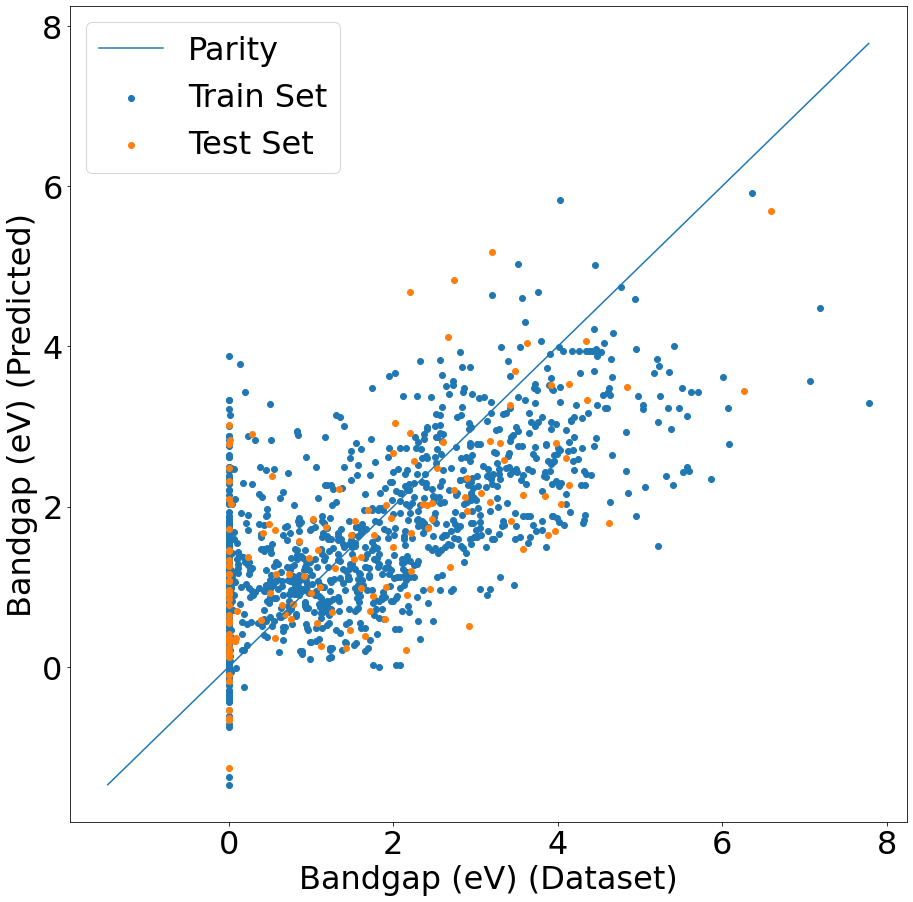

In [85]:
model_to_plot = 'r2_4term'
DigitalEcosystem.utils.figures.publication_parity_plot(train_y_true = sisso_data_train['bandgap (eV)'],
                                                       train_y_pred = sisso_data_train[model_to_plot],
                                                       test_y_true = sisso_data_test['bandgap (eV)'],
                                                       test_y_pred = sisso_data_test[model_to_plot],
                                                       axis_label = "Bandgap (eV)",
                                                       filename = "sisso_2dm_bandgap_parity.jpeg")